In [1]:
import scanpy as sc
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Topic Modeling 

In [4]:
# Start From Here after imports in cell 1
adata = sc.read_h5ad('control_annotated_data.h5ad')
sc.pp.filter_cells(adata, min_genes=100, inplace=True)
sc.pp.filter_genes(adata, min_cells=3, inplace=True)
print(adata)

AnnData object with n_obs × n_vars = 96303 × 38712
    obs: 'cell_type_category', 'manuscript_id', 'subclass_id', 'disease', 'subject_id', 'age', 'n_genes'
    var: 'HGNC_Alt_GeneID', 'n_cells'


In [5]:
import pickle
with open('hv_genes.pkl', 'rb') as f:
    hv_genes = pickle.load(f)

In [6]:
adata = adata[:, adata.var_names.isin(hv_genes)]

In [7]:
print(adata)

View of AnnData object with n_obs × n_vars = 96303 × 4443
    obs: 'cell_type_category', 'manuscript_id', 'subclass_id', 'disease', 'subject_id', 'age', 'n_genes'
    var: 'HGNC_Alt_GeneID', 'n_cells'


In [25]:
#print(adata.var['HGNC_Alt_GeneID'][35])

## Create BoW Documents

In [8]:
docs = []
for i in range(len(adata.obs_names)):
    doc = adata[i, :]
    form = []
    doc_vals = doc.X
    for row, col in zip(*doc_vals.nonzero()):
        val = int(doc_vals[row, col])
        name = doc.var['HGNC_Alt_GeneID'][col]
        for j in range(val):
            form.append(name)
    docs.append(form)
    if (i % 10000) == 0:
        print(f"Finished Doc {i}")

Finished Doc 0
Finished Doc 10000
Finished Doc 20000
Finished Doc 30000
Finished Doc 40000
Finished Doc 50000
Finished Doc 60000
Finished Doc 70000
Finished Doc 80000
Finished Doc 90000


In [9]:
with open('bow_model.pkl', 'wb') as f:
    pickle.dump(docs, f)

# Model Code (Start Here)

In [21]:
import pickle
with open('bow_model.pkl', 'rb') as f:
    bow_model = pickle.load(f)

In [22]:
print(len(bow_model))

96303


In [23]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from pprint import pprint
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models 
from tqdm import tqdm

id2word = corpora.Dictionary(bow_model)
# Create Corpus
texts = bow_model
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 2), (3, 1), (4, 2), (5, 4), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 6), (12, 2), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 4), (19, 1), (20, 1), (21, 2), (22, 3), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 3), (37, 3), (38, 1), (39, 5), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 3), (58, 2), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 3), (84, 7), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 5), (96, 2), (97, 1), (98, 1), (99, 1), (100, 3), (101, 4), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [159]:
subjects = pd.unique(adata.obs['subject_id']).to_list()
corpus_array = np.array(corpus).reshape(-1, )
pbar = tqdm([5, 10, 20, 30, 40])
coherence = []
for num in pbar:
    for i, s in enumerate(subjects):
        temp = np.array([adata.obs['subject_id'] != s],dtype=bool).reshape(-1, )
        val_set = list(corpus_array[temp])
        lda_model = LdaMulticore(corpus=val_set,
                         id2word=id2word,
                         num_topics=num, 
                         random_state=100,
                         iterations=50,
                         passes=5,
                         workers=2,
                         per_word_topics=True)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=bow_model, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence.append(coherence_lda)
        print(i, 'Num of topics: ', num,' Coherence Score: ', coherence_lda)

C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0 Num of topics:  5  Coherence Score:  0.3065231080521841
1 Num of topics:  5  Coherence Score:  0.30117855977701097
2 Num of topics:  5  Coherence Score:  0.3155866705530696
3 Num of topics:  5  Coherence Score:  0.3065231080521841
4 Num of topics:  5  Coherence Score:  0.29777560880534865
5 Num of topics:  5  Coherence Score:  0.3065231080521841
6 Num of topics:  5  Coherence Score:  0.2978459682840436
7 Num of topics:  5  Coherence Score:  0.29777560880534865
8 Num of topics:  5  Coherence Score:  0.29777560880534865
9 Num of topics:  5  Coherence Score:  0.3091277985989501
10 Num of topics:  5  Coherence Score:  0.300256129476075
11 Num of topics:  5  Coherence Score:  0.29910661124460025
12 Num of topics:  5  Coherence Score:  0.2978459682840435
13 Num of topics:  5  Coherence Score:  0.29432620729128656
14 Num of topics:  5  Coherence Score:  0.30197392436646153
15 Num of topics:  5  Coherence Score:  0.3067886891276904
16 Num of topics:  5  Coherence Score:  0.301740245996789
17

 20%|███████████████▏                                                            | 1/5 [2:48:17<11:13:11, 10097.93s/it]

27 Num of topics:  5  Coherence Score:  0.2936584117294254
0 Num of topics:  10  Coherence Score:  0.3087244210438399
1 Num of topics:  10  Coherence Score:  0.30951085187259425
2 Num of topics:  10  Coherence Score:  0.2968878022535525
3 Num of topics:  10  Coherence Score:  0.3118139708215552
4 Num of topics:  10  Coherence Score:  0.3204744562302246
5 Num of topics:  10  Coherence Score:  0.32104162255153096
6 Num of topics:  10  Coherence Score:  0.3205779577448452
7 Num of topics:  10  Coherence Score:  0.3214597446686012
8 Num of topics:  10  Coherence Score:  0.318369271953295
9 Num of topics:  10  Coherence Score:  0.31526517238800944
10 Num of topics:  10  Coherence Score:  0.3179980067003531
11 Num of topics:  10  Coherence Score:  0.32336540742283204
12 Num of topics:  10  Coherence Score:  0.3220784810615156
13 Num of topics:  10  Coherence Score:  0.31842945491411057
14 Num of topics:  10  Coherence Score:  0.3234235666623081
15 Num of topics:  10  Coherence Score:  0.3194

 40%|██████████████████████████████▊                                              | 2/5 [5:59:57<9:06:07, 10922.36s/it]

27 Num of topics:  10  Coherence Score:  0.3233491242254717
0 Num of topics:  20  Coherence Score:  0.2958175410060046
1 Num of topics:  20  Coherence Score:  0.291982797223599
2 Num of topics:  20  Coherence Score:  0.3043429180990946
3 Num of topics:  20  Coherence Score:  0.2936336221440841
4 Num of topics:  20  Coherence Score:  0.29228033153367117
5 Num of topics:  20  Coherence Score:  0.28659915179308915
6 Num of topics:  20  Coherence Score:  0.2938615522416185
7 Num of topics:  20  Coherence Score:  0.2900922580766122
8 Num of topics:  20  Coherence Score:  0.29898158629277166
9 Num of topics:  20  Coherence Score:  0.29708098454561543
10 Num of topics:  20  Coherence Score:  0.29343323071534294
11 Num of topics:  20  Coherence Score:  0.2920101155549683
12 Num of topics:  20  Coherence Score:  0.2953066398504229
13 Num of topics:  20  Coherence Score:  0.2909554812249648
14 Num of topics:  20  Coherence Score:  0.29143608191693804
15 Num of topics:  20  Coherence Score:  0.29

 60%|██████████████████████████████████████████████▏                              | 3/5 [9:55:32<6:52:58, 12389.24s/it]

27 Num of topics:  20  Coherence Score:  0.29900411859062037
0 Num of topics:  30  Coherence Score:  0.28695073745486505
1 Num of topics:  30  Coherence Score:  0.3043009964617403
2 Num of topics:  30  Coherence Score:  0.296249087581246
3 Num of topics:  30  Coherence Score:  0.2933891387349536
4 Num of topics:  30  Coherence Score:  0.2963853824178058
5 Num of topics:  30  Coherence Score:  0.29927703423957214
6 Num of topics:  30  Coherence Score:  0.29814622989060474
7 Num of topics:  30  Coherence Score:  0.29012160939112613
8 Num of topics:  30  Coherence Score:  0.2979618782027528
9 Num of topics:  30  Coherence Score:  0.29511342039490107
10 Num of topics:  30  Coherence Score:  0.30020638658636584
11 Num of topics:  30  Coherence Score:  0.3018493102317879
12 Num of topics:  30  Coherence Score:  0.2957674346302786
13 Num of topics:  30  Coherence Score:  0.29956264232414187
14 Num of topics:  30  Coherence Score:  0.30343981927897207
15 Num of topics:  30  Coherence Score:  0

 80%|████████████████████████████████████████████████████████████▊               | 4/5 [14:12:28<3:46:24, 13584.12s/it]

27 Num of topics:  30  Coherence Score:  0.30016712984923705
0 Num of topics:  40  Coherence Score:  0.30788806157399107
1 Num of topics:  40  Coherence Score:  0.2978617689891915
2 Num of topics:  40  Coherence Score:  0.2903049831845795
3 Num of topics:  40  Coherence Score:  0.2961923962135722
4 Num of topics:  40  Coherence Score:  0.3034421681174707
5 Num of topics:  40  Coherence Score:  0.3035255079570855
6 Num of topics:  40  Coherence Score:  0.3090558712456314
7 Num of topics:  40  Coherence Score:  0.29962124334668616
8 Num of topics:  40  Coherence Score:  0.3007464249740218
9 Num of topics:  40  Coherence Score:  0.2995997810142893
10 Num of topics:  40  Coherence Score:  0.29230388047865363
11 Num of topics:  40  Coherence Score:  0.30243417496046965
12 Num of topics:  40  Coherence Score:  0.30368168574807564
13 Num of topics:  40  Coherence Score:  0.29617124661055944
14 Num of topics:  40  Coherence Score:  0.3035494518226078
15 Num of topics:  40  Coherence Score:  0.

100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [19:42:24<00:00, 14188.88s/it]

27 Num of topics:  40  Coherence Score:  0.30096295593417577


C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<function matplotlib.pyplot.show(close=None, block=None)>

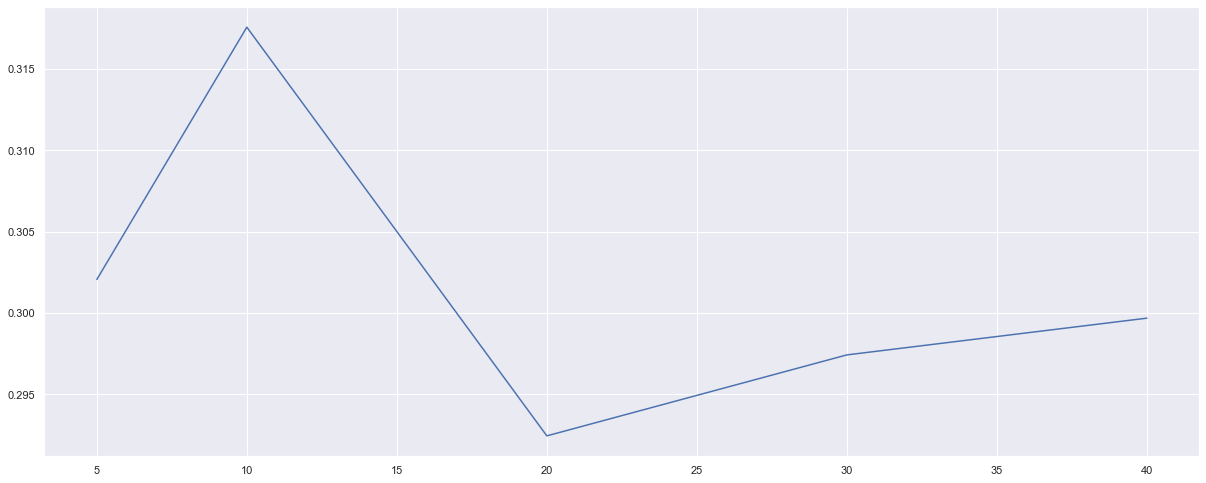

In [166]:
a = np.array(coherence).reshape(-1, 28)
coherence_plot = np.mean(a, axis = 1)
num_topics = [5, 10, 20, 30, 40]
plt.plot(num_topics, coherence_plot)
plt.show

In [25]:


pbar = tqdm([5, 10, 15, 20, 25, 30, 40, 50])
for num in pbar:
    lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=num, 
                         random_state=100,
                         iterations=200,
                         passes=5,
                         workers=2,
                         per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=bow_model, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Num of topics: ', num,' Coherence Score: ', coherence_lda)

C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
 12%|██████████▍                                                                        | 1/8 [07:03<49:25, 423.59s/it]

Num of topics:  5  Coherence Score:  0.29777560880534865


 25%|████████████████████▊                                                              | 2/8 [15:53<48:38, 486.34s/it]

Num of topics:  10  Coherence Score:  0.32345348894338266


 38%|███████████████████████████████▏                                                   | 3/8 [26:02<45:09, 541.96s/it]

Num of topics:  15  Coherence Score:  0.2915061185525161


 50%|█████████████████████████████████████████▌                                         | 4/8 [36:47<38:50, 582.72s/it]

Num of topics:  20  Coherence Score:  0.30692399688431815


 62%|███████████████████████████████████████████████████▉                               | 5/8 [48:40<31:29, 629.70s/it]

Num of topics:  25  Coherence Score:  0.3067318072640575


 75%|████████████████████████████████████████████████████████████▊                    | 6/8 [1:01:05<22:18, 669.07s/it]

Num of topics:  30  Coherence Score:  0.3095335344421032


 88%|██████████████████████████████████████████████████████████████████████▉          | 7/8 [1:19:49<13:37, 817.87s/it]

Num of topics:  40  Coherence Score:  0.3006907164418447


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:39:52<00:00, 749.08s/it]

Num of topics:  50  Coherence Score:  0.30009780704276606


C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<function matplotlib.pyplot.show(close=None, block=None)>

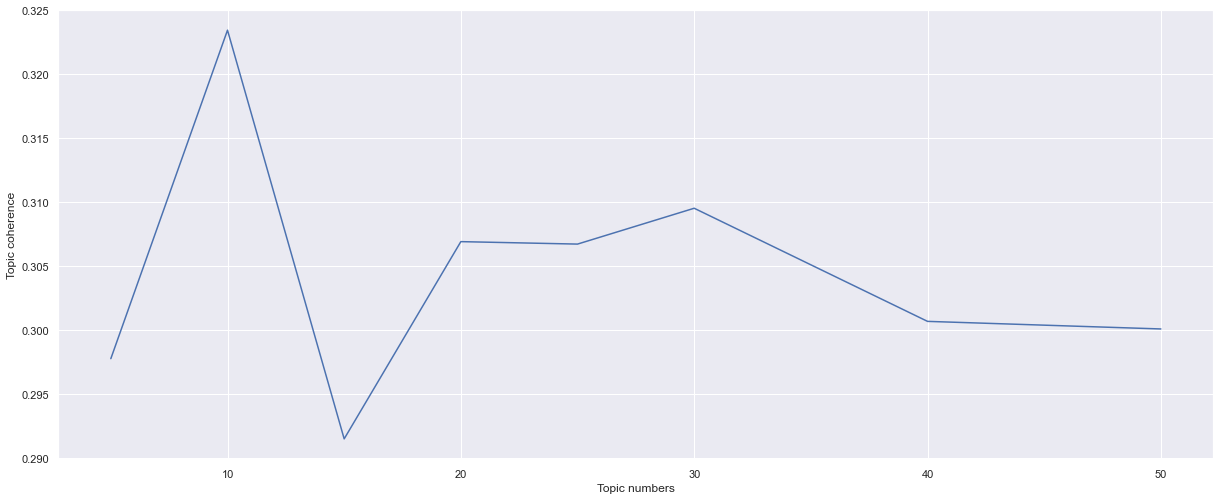

In [168]:
coherence2 = [0.29777560880534865, 0.32345348894338266, 0.2915061185525161, 0.30692399688431815, 0.3067318072640575, 0.3095335344421032, 0.3006907164418447, 0.30009780704276606]
num_topics = [5, 10, 15, 20, 25, 30, 40, 50]
plt.plot(num_topics, coherence2) 
plt.xlabel('Topic numbers')
plt.ylabel('Topic coherence')
plt.show


In [47]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=10, 
                         random_state=100,
                         iterations=200,
                         passes=5,
                         workers=2,
                         per_word_topics=True)

C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"SCGB1A1" + 0.030*"SCGB3A1" + 0.021*"CCL4" + 0.015*"SYTL3" + '
  '0.014*"CD69" + 0.014*"CNOT6L" + 0.012*"GNLY" + 0.012*"CCL5" + '
  '0.011*"IFITM2" + 0.011*"FYN"'),
 (1,
  '0.028*"HLA-DPB1" + 0.027*"FOS" + 0.026*"APOE" + 0.020*"HLA-DPA1" + '
  '0.018*"CXCL8" + 0.017*"NFKBIA" + 0.016*"AREG" + 0.014*"ENSG00000234287" + '
  '0.013*"SPP1" + 0.013*"ZFP36"'),
 (2,
  '0.226*"SFTPC" + 0.044*"SFTPB" + 0.031*"SFTPA1" + 0.027*"SFTPA2" + '
  '0.020*"SLPI" + 0.010*"MACROD2" + 0.009*"CXCL2" + 0.008*"NAPSA" + '
  '0.007*"PDE4D" + 0.007*"NEDD4L"'),
 (3,
  '0.320*"ENSG00000240040" + 0.082*"IGLC3" + 0.071*"IGLL5" + 0.063*"IGLC2" + '
  '0.057*"IGHA1" + 0.056*"IGHM" + 0.044*"IGHG3" + 0.044*"JCHAIN" + '
  '0.039*"IGHG2" + 0.035*"IGHGP"'),
 (4,
  '0.022*"ATP1B3" + 0.020*"ZEB2" + 0.016*"JARID2" + 0.016*"SIPA1L1" + '
  '0.015*"DOCK4" + 0.015*"ELL2" + 0.015*"NAMPT" + 0.014*"SLC16A10" + '
  '0.014*"ZNF331" + 0.013*"KYNU"'),
 (5,
  '0.031*"C1QB" + 0.031*"C1QA" + 0.029*"APOE" + 0.027*"FABP4" + 0.022

C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
import pyLDAvis
import pyLDAvis.gensim_models 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.091457  0.075986       1        1  29.551558
4      0.101377  0.118146       2        1  20.537319
8      0.048545  0.032321       3        1  11.811470
1      0.075536  0.124091       4        1  10.170072
2     -0.005939 -0.270501       5        1   7.884918
6      0.031804 -0.224513       6        1   5.619898
7      0.089805  0.146081       7        1   5.371160
9      0.055923 -0.131904       8        1   4.177112
0      0.001548  0.068701       9        1   3.716789
3     -0.490055  0.061592      10        1   1.159704, topic_info=                 Term          Freq         Total Category  logprob  loglift
1485            SFTPC  1.628423e+06  1.628423e+06  Default  30.0000  30.0000
1751  ENSG00000240040  3.392630e+05  3.392630e+05  Default  29.0000  29.0000
231            S100A8  4.523070e+05  4.523070e+05  Default  28.0000  28.0000
232            S100A9  4.916210e+05  4.916210e+05  Default  27.0000  27.0000
15               APOE  1.063131e+06  1.063131e+06  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
163         LINC-PINT  2.074910e+03  6.920190e+05  Topic10  -6.2352  -1.3527
144          HSP90AA1  1.630629e+03  3.414482e+05  Topic10  -6.4761  -0.8872
387              ELL2  1.480167e+03  4.231793e+05  Topic10  -6.5729  -1.1986
490               JUN  1.338424e+03  2.836742e+05  Topic10  -6.6736  -0.8993
174       MIR4435-2HG  9.834661e+02  6.936308e+04  Topic10  -6.9817   0.2010

[666 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.162748    ABCA1
0         2  0.737120    ABCA1
0         3  0.005625    ABCA1
0         4  0.037068    ABCA1
0         5  0.002506    ABCA1
...     ...       ...      ...
1507      5  0.940850  ZNF385B
1507      6  0.003986  ZNF385B
1507      7  0.002123  ZNF385B
1507      8  0.014174  ZNF385B
1507      9  0.000189  ZNF385B

[4171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 9, 2, 3, 7, 8, 10, 1, 4])

In [112]:
from tqdm import trange
topic_nums = 10
get_document_topics = lda_model.get_document_topics(corpus)
doc_topic_distr = np.zeros((len(adata.obs_names), topic_nums))
for i in trange(len(adata.obs_names)):
    temp = get_document_topics[i]
    for j in range(len(temp)):
        doc_topic_distr[i, temp[j][0]-1] = temp[j][1]
print(doc_topic_distr)

C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|███████████████████████████████████████████████████████████████████████████| 96303/96303 [01:38<00:00, 977.65it/s]

[0.05938196 0.         0.         0.01128983 0.05941009 0.
 0.6248765  0.24418759 0.         0.        ]


C:\Users\97179\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

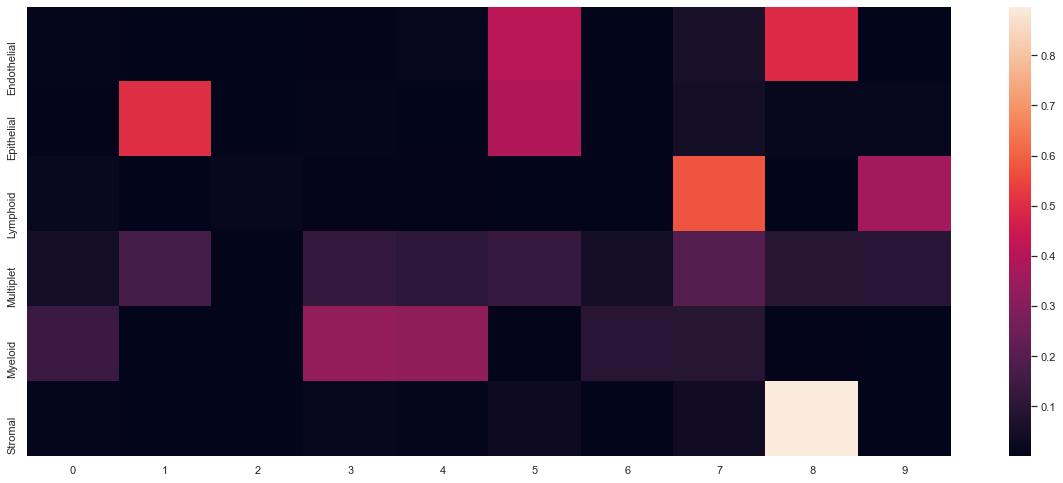

In [115]:
import seaborn as sns
cell_category = list(adata.obs['cell_type_category'])
cell_distr_df = pd.DataFrame(doc_topic_distr, index=cell_category)
grouped_distr = cell_distr_df.groupby(by=cell_distr_df.index).mean()
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.heatmap(grouped_distr)